In [1]:
from netCDF4 import *
import matplotlib.pyplot as plt
import matplotlib.colors as co
from path import Path
import xarray as xr
import numpy as np
import math
import scipy.interpolate as interp
import scipy.stats as stats
import tkinter as tk
import cv2
import matplotlib
import pandas as pd

from matplotlib import rc

font = {"family": "serif", "weight": "normal", "size": 13}
rc("font", **font)
rc("text", usetex=True)

In [2]:
# path = Path(r"C:\\Users\\albou\Desktop\\The Ocean Cleanup\Statistiques\data\\GLORYS\\GPGP_flow_2022_06;09_processed.nc")
# dsr = xr.open_dataset(path, engine="netcdf4")
# path = Path(r"C:\\Users\\albou\Desktop\\The Ocean Cleanup\Statistiques\data\\GLORYS\\GPGP_flow_2022_06;09.nc")
# dsrf = xr.open_dataset(path, engine="netcdf4")

# owp = dsr["owp_th"]
# vorticity = dsr["vorticity"]
# speed = dsr["speed"]
# trange = [0,40,80,120]

In [ ]:
path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\data\\MULTIOBS geostrophic\\Multiobs_2024_06;09_processed.nc")
dsr = xr.open_dataset(path, engine="netcdf4")
path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\data\\MULTIOBS geostrophic\\Multiobs_2024_06;09.nc")
dsrf = xr.open_dataset(path, engine="netcdf4")

owp = dsr["owp_th"]
vorticity = dsr["vorticity"]
speed = dsr["speed"]
trange = [0,25,75,100]

## Local minimum detection + speed threshold filtering

In [4]:
# pos_min = []

# for t,time in enumerate(trange):
#     pos_min.append([])
#     print("Time : "+str(time))
#     for i in range(dsr["latitude"].shape[0]):
#         for j in range(dsr["longitude"].shape[0]):
#             if owp[time,i,j] < owp[time,i,j-1] and owp[time,i,j] < owp[time,i,j+1] and owp[time,i,j] < owp[time,i-1,j] and owp[time,i,j] < owp[time,i+1,j] :
#                 if np.abs(speed[time,i,j]) < 0.10 : 
#                     pos_min[t].append([dsr["latitude"][i],dsr["longitude"][j],owp[time,i,j]])
# print("Num points : "+ str(len(pos_min[t])))
   

In [5]:
# Detect Okubo Weiss contours with OpenCV and filter large ones and noise
pos_min = []

for t,time in enumerate(trange) :
    pos_min.append([])
    print("Time : "+str(time))
    min = np.min(owp)
    max = np.max(owp)
    owp_fit_gray = np.array((owp[t,:,:]+min)*255/(max-min), dtype=np.uint8)
    owp_rgb = cv2.cvtColor(owp_fit_gray, cv2.COLOR_GRAY2RGB)

    _,owp_tresh = cv2.threshold(owp_fit_gray, 62, 255, cv2.THRESH_BINARY)


    contours,_ = cv2.findContours(owp_tresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contours_filtered = []
    height = dsr["latitude"].shape[0]
    width = dsr["longitude"].shape[0]

    #contour filtering
    for c,cnt in enumerate(contours) :
        rect = cv2.boundingRect(cnt)
        if float(rect[2]/width) > 0.01 and float(rect[3]/height) > 0.01 and float(rect[2]/width) < 0.5 and float(rect[3]/height) < 0.5 :
            contours_filtered.append(cnt)
            pos_min[t].append([dsr["latitude"][int(rect[1]+rect[3]/2)],dsr["longitude"][int(rect[0]+rect[2]/2)],owp[t,int(rect[1]+rect[3]/2),int(rect[0]+rect[2]/2)]])

    img = cv2.drawContours(owp_rgb, contours_filtered,-1,(0,255,20), 2)
    cv2.imshow('owp', img)
cv2.waitKey(0)

# closing all open windows
cv2.destroyAllWindows()

Time : 0
Time : 25
Time : 75


c:\Users\albou\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)
c:\Users\albou\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)
c:\Users\albou\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)


Time : 100


c:\Users\albou\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)


In [6]:
# pos_min = []


# for t,time in enumerate(trange):
#     img = np.array(owp[t,:,:])

#     pos_min.append([])
#     print("Time : "+str(time))
#     for i in range(dsr["latitude"].shape[0]):
#         for j in range(dsr["longitude"].shape[0]):
#             if owp[time,i,j] < owp[time,i,j-1] and owp[time,i,j] < owp[time,i,j+1] and owp[time,i,j] < owp[time,i-1,j] and owp[time,i,j] < owp[time,i+1,j] :
#                 if np.abs(speed[time,i,j]) < 0.10 : 
#                     pos_min[t].append([dsr["latitude"][i],dsr["longitude"][j],owp[time,i,j]])
# print("Num points : "+ str(len(pos_min[t])))
   

## Show detection points on vorticity and owp map

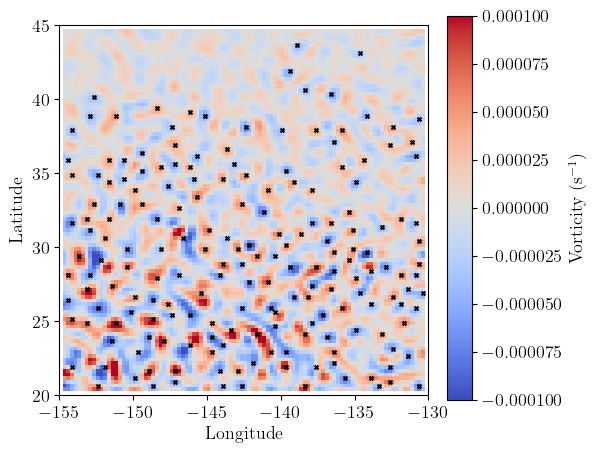

In [7]:
fig, ax = plt.subplots()
# plt.quiver(dsrf["uo"], dsrf["vo"])

value = 0.00010
im = ax.pcolormesh(dsr["longitude"], dsr["latitude"], vorticity[0], cmap="coolwarm", vmax =value, vmin = -value)
coco = ['red','purple','blue','green','orange']
for t in [0]:
    for i in range(len(pos_min[t])):
        ax.scatter(pos_min[t][i][1], pos_min[t][i][0],s=8, color= "black", marker = 'x')
        # ax.text(pos_min[t][i][1], pos_min[t][i][0],str(t), fontsize=10)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
cbar_ax = fig.add_axes([0.83, 0.10, 0.04, 0.8])
fig.colorbar(im,cax = cbar_ax,label = "Vorticity (s$^{-1}$)")
fig.savefig("owp_vortex_detection.pdf")


## Function definition

In [8]:
def circulation(ds,N,W,radius,time):
    #compute the circulation around a circle of given radius (in km) centered on (N,W) at given time index

    if W > 0 :
        W -= 360
    R = 6.371e6 #radius of the Earth
    pR = 2*np.pi*R

    u = np.array(ds["uo"])
    v = np.array(ds["vo"])
        
    pts = 40

    xcircle = np.cos(np.linspace(0,6.28,pts))*(radius*1000) 
    ycircle = np.sin(np.linspace(0,6.28,pts))*(radius*1000)

    # Alternative square path
    # xcircle = np.concatenate([np.linspace(-1,1,int(pts/4)),np.linspace(1,1,int(pts/4)),np.linspace(1,-1,int(pts/4)),np.linspace(-1,-1,int(pts/4))])*radius*1000
    # ycircle = np.concatenate([np.linspace(-1,-1,int(pts/4)),np.linspace(-1,1,int(pts/4)),np.linspace(1,1,int(pts/4)),np.linspace(1,-1,int(pts/4))])*radius*1000

    ycircle /= pR/360
    ycircle += np.array(N)
    xcircle /= pR*np.cos(np.deg2rad(ycircle))/360
    xcircle += np.array(W) 

    circulation = 0

    # Xc,Yc = np.meshgrid(np.linspace(np.min(ds["longitude"]),np.max(ds["longitude"]),u.shape[2]),np.linspace(np.min(ds["latitude"]),np.max(ds["latitude"]),u.shape[3]), indexing='ij')
    Xc = np.linspace(np.min(ds["longitude"]),np.max(ds["longitude"]),u.shape[3])
    Yc = np.linspace(np.min(ds["latitude"]),np.max(ds["latitude"]),u.shape[2])


    ui = u[time,0,:,:].astype("float64")
    vi = v[time,0,:,:].astype("float64")

    fu = interp.RegularGridInterpolator((Xc,Yc), ui.T)
    fv = interp.RegularGridInterpolator((Xc,Yc), vi.T)

    for i in range(1,len(xcircle)) :
        
        if xcircle[i] < np.min(Xc) or xcircle[i] > np.max(Xc) or ycircle[i] < np.min(Yc) or ycircle[i] > np.max(Yc):
            return 0,0

        dlx = (xcircle[i] - xcircle[i-1])*pR*np.cos(np.deg2rad(ycircle[i]))/360
        dly = (ycircle[i] - ycircle[i-1])*pR/360

        ul = fu((xcircle[i],ycircle[i]))
        vl = fv((xcircle[i],ycircle[i]))


        circulation += ul*dlx + vl*dly

        tg_spd = circulation/(2*3.1415*radius*1000)
    
    return circulation,tg_spd



In [9]:
def lamb_oseen_fit(spd_profile,circ_profile):
    #fit a lamb-oseen profile to the given speed and circulation profiles (1D arrays)
    spd_argmax = np.argmax(np.abs(spd_profile))
    rmax = 1+spd_argmax*2
    circ = circ_profile[spd_argmax]/0.71
    return rmax,circ

In [10]:
def flat(array) :
    array_ret = []
    for i in range(len(array)):
        array_ret.extend(array[i])
    return array_ret

## Lamb oseen approximation computation with time series

In [11]:
#velocity profile
spd_profile = []
#circulation profile
circulation_profile = []    
coords = []
rmax = []   
circ = []
ids = []

for t,time in enumerate(trange) :
    print("Time : "+str(t))
    rmax.append([])
    circ.append([])
    coords.append([])
    ids.append([])
    for i in range(len(pos_min[t])):
        for j in range(1,100,2) :
            result = circulation(dsrf,pos_min[t][i][0],pos_min[t][i][1],radius=j,time=t)
            if np.isnan(result[0])  or (len(spd_profile) > 0 and np.abs(spd_profile[-1]) >np.abs(result[1])) :
                #extraction of the parameters
                rmaxi,circi = lamb_oseen_fit(spd_profile,circulation_profile)
                rmax[-1].append(rmaxi)
                circ[-1].append(circi)
                coords[-1].append([pos_min[t][i][0],pos_min[t][i][1],j])
                
                if t ==0:
                    ids[-1].append(i)
                else:
                    for k in range(len(ids[-2])):
                        dist = np.power(coords[-2][k][0]-coords[-1][-1][0],2)+ np.power(coords[-2][k][1]-coords[-1][-1][1],2)
                        if dist < 1 :
                            ids[-1].append(ids[-2][k])
                            break
                spd_profile = []
                circulation_profile = []
                break
            spd_profile.append(result[1])
            circulation_profile.append(result[0])

Time : 0
Time : 1
Time : 2
Time : 3


### Create a csv file with all the parameters

In [12]:
rmax_flat = flat(rmax)
circ_flat = flat(circ)

dict_data = {"rmax": rmax_flat, "circ": circ_flat}
# df = pd.DataFrame(dict_data)
# df.to_csv("multiobs2024.csv", index=False)

### Plot the correlation of rc and circulation

0.577149501946724 9.222605227599062e-142
-55408.524898984506 2055.0335087513736


Text(0, 0.5, 'Circulation $m^2.s^{-1}$')

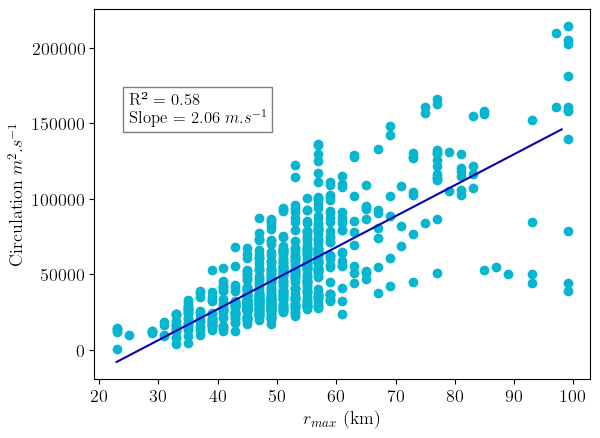

In [13]:
j = 0

for j in range(len(rmax)):
    plt.scatter(rmax[j],np.abs(circ[j]),c = "#06b6d1")

reg = stats.linregress(flat(rmax),np.abs(flat(circ)))
plt.plot(np.arange(np.min(flat(rmax)),np.max(flat(rmax)),1),reg.intercept+reg.slope*np.arange(np.min(flat(rmax)),np.max(flat(rmax)),1),c = "#0603b0")
plt.text(25, 150000, 'R² = '+str(round(reg.rvalue**2,2))+'\nSlope = '+str(round(reg.slope/1000,2))+' $m.s^{-1}$', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
print(reg.rvalue**2,reg.pvalue)
print(reg.intercept,reg.slope)
plt.xlabel("$r_{max}$ (km)")
plt.ylabel("Circulation $m^2.s^{-1}$")

### Comparison of different models

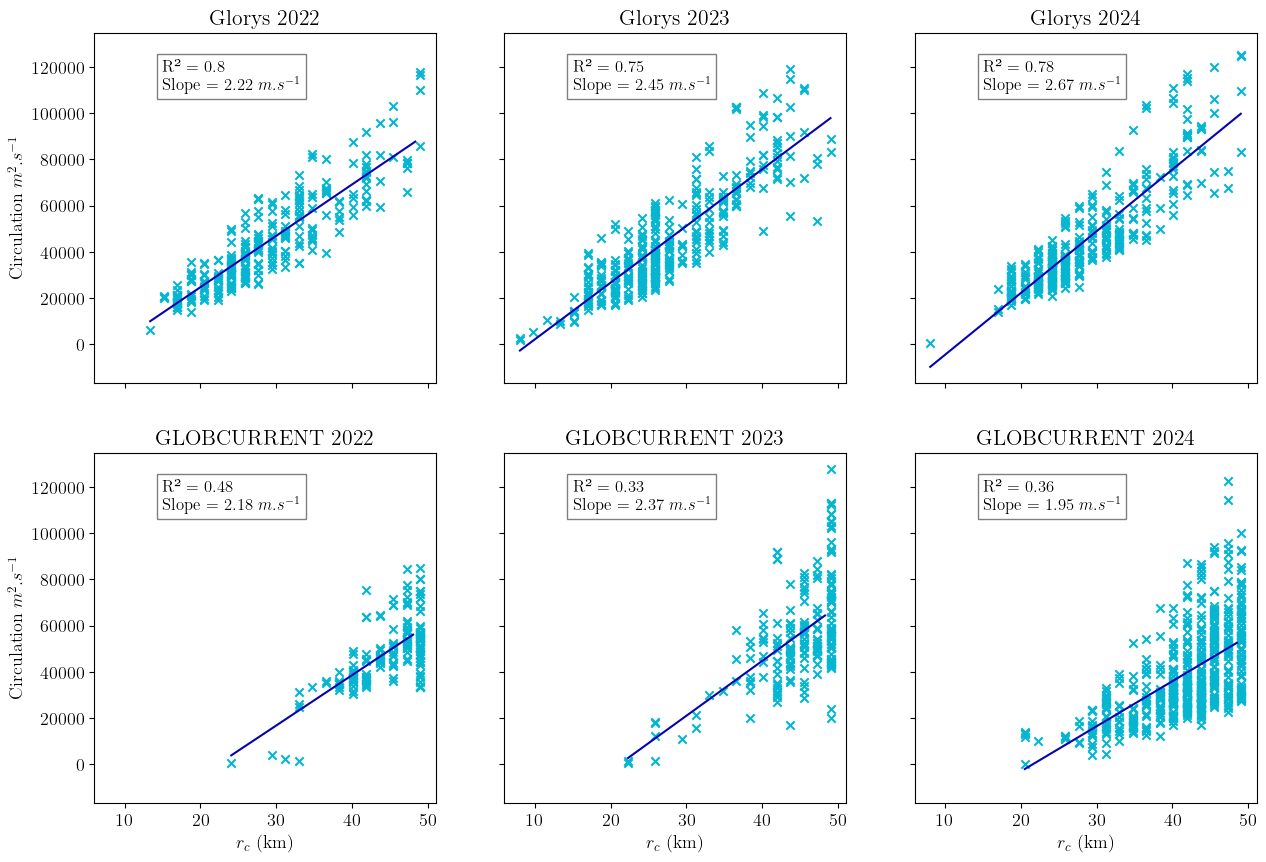

In [14]:
files = ['glorys2022.csv','glorys2023.csv','glorys2024.csv','multiobs2022.csv','multiobs2023.csv','multiobs2024.csv']
# names = ['GLORYS 2022','GLORYS 2023','GLORYS 2024','GLOBCURRENT 2022','GLOBCURRENT 2023','GLOBCURRENT 2024']
names = ['Glorys 2022','Glorys 2023','Glorys 2024','GLOBCURRENT 2022','GLOBCURRENT 2023','GLOBCURRENT 2024']

fig, ax = plt.subplots(2,3,figsize=(15,10), sharex=True, sharey=True)

slopes = []
intercepts = []
n = 10

for f,file in enumerate(files):

    path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Statistiques\\"+str(file))
    df = pd.read_csv(path)
    rmax = []
    circ = []
    for i in range(len(df['rmax'])):
        rmax.append(df['rmax'][i]/math.sqrt(1.2564))
        circ.append(df['circ'][i])

    popped = 0
    for i in range(len(rmax)) :
        if rmax[i-popped] > 50 :
            rmax.pop(i-popped)
            circ.pop(i-popped) 
            popped += 1


    ax[f // 3, f % 3 ].scatter(rmax,np.abs(circ),c = "#06b6d1", marker='x')
    reg = stats.linregress(rmax,np.abs(circ))
    if f < 3 :
        slopes.append(reg.slope)
        intercepts.append(reg.intercept)
    ax[f // 3, f % 3].plot(np.arange(np.min(rmax),np.max(rmax),1),reg.intercept+reg.slope*np.arange(np.min(rmax),np.max(rmax),1),c = "#0603b0")
    ax[f // 3, f % 3].text(15, 110000, 'R² = '+str(round(reg.rvalue**2,2))+'\nSlope = '+str(round(reg.slope/1000,2))+' $m.s^{-1}$', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    ax[f // 3, f % 3].set_title(names[f])
    if f // 3 == 1 :
        ax[f // 3, f % 3].set_xlabel("$r_c$ (km)")
    if f % 3 == 0 :
        ax[f // 3, f % 3].set_ylabel("Circulation $m^2.s^{-1}$")
plt.show()

fig.savefig("lamb_oseen_ratio.pdf")

### Approximation for small radiuses

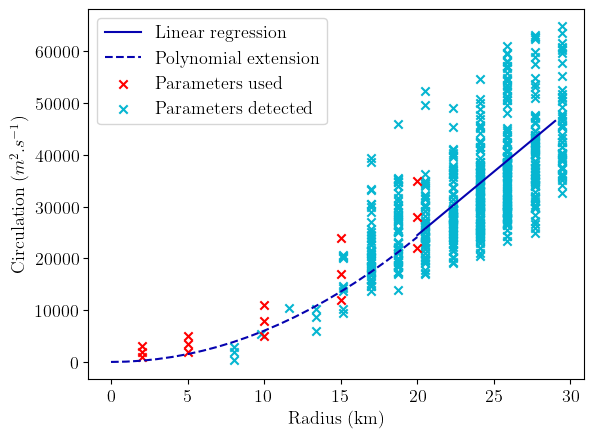

In [15]:
slope = np.mean(slopes)
intercept = np.mean(intercepts)

rtest = [2,5,10,15,20,2,5,10,15,20,2,5,10,15,20]
circtest = [1000,2000,5000,12000,22000,2000,3500,8000,17000,28000,3000,5000,11000,24000,35000]
for f,file in enumerate(files):
    if f < 3 :
        path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Statistiques\\"+str(file))
        df = pd.read_csv(path)
        rmax = []
        circ = []
        for i in range(len(df['rmax'])):
            if df['rmax'][i]/math.sqrt(1.2564) < 30 :
                rmax.append(df['rmax'][i]/math.sqrt(1.2564))
                circ.append(df['circ'][i])
        ax = plt.gca()
        scatter_points = ax.scatter(rmax,np.abs(circ),c = "#06b6d1", marker='x')
 
line_regr, = ax.plot(np.arange(20,30,1),intercept+slope*np.arange(20,30,1),c = "#0603b0")
line_proj, = ax.plot(np.arange(0,21,1),60.3*np.arange(0,21,1)**2,c = "#0603b0", linestyle = '--')
scatter_choice = ax.scatter(rtest,circtest,c='red',marker='x')
plt.xlabel('Radius (km)')
plt.ylabel('Circulation ($m^2.s^{-1}$)')
ax.legend([line_regr,line_proj,scatter_choice,scatter_points],['Linear regression','Polynomial extension','Parameters used','Parameters detected'])
plt.savefig('paramchoice.pdf')

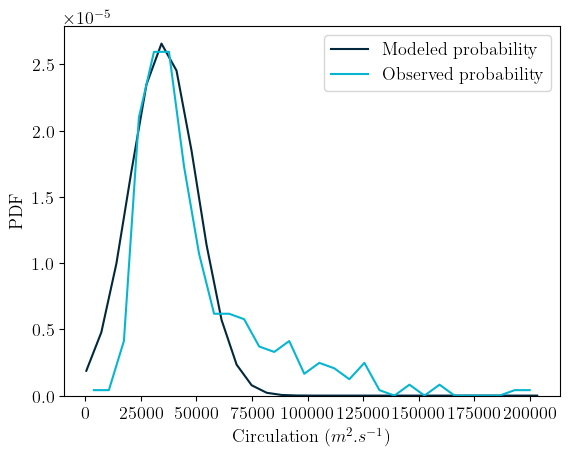

In [47]:
for f,file in enumerate(files):
    if f < 3 :
        path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Statistiques\\"+str(file))
        df = pd.read_csv(path)
        circ = []
        for i in range(len(df['rmax'])):
                circ.append(df['circ'][i])
        ax = plt.gca()
Y,X,_ = plt.hist(np.abs(circ), bins = 30,density = True,alpha =0)

mu = 35000
var = 15000


plt.plot(X,np.exp(-1/2*np.power((X - mu)/var,2)) / (var*np.sqrt(2 * np.pi)),label='Modeled probability', c = "#01283c")
plt.plot((X[1:]+X[:-1])/2,Y,label='Observed probability', c = "#06b6d1") 

plt.legend()
plt.xlabel('Circulation ($m^2.s^{-1}$)')
plt.ylabel("PDF")

plt.savefig('circulation_distribution.pdf')


## Circulation computation for each valid point

In [ ]:
#for each detected vortex, compute circulation and speed profiles
spd_profile = []
circulation_profile = []
coords = []
for t,time in enumerate(trange):
    for i in range(len(pos_min[t])) :
        spd_profile.append([]) 
        circulation_profile.append([])
        print(t)
        print(pos_min[t][i][0],pos_min[t][i][1])
        for j in range(1,100,2) :
            result = circulation(dsrf,N=pos_min[t][i][0],W=pos_min[t][i][1],radius=j,time=t)
            if np.isnan(result[0])  or result[0] == 0 :
                spd_profile.pop()
                circulation_profile.pop()
                break
                
            circulation_profile[-1].append(result[0])
            spd_profile[-1].append(result[1])
            coords.append([pos_min[t][i][0],pos_min[t][i][1],j])

0
<xarray.DataArray 'latitude' ()> Size: 4B
array(43.625, dtype=float32)
Coordinates:
    latitude  float32 4B 43.62
Attributes:
    standard_name:  latitude
    units:          degrees_north
    axis:           Y <xarray.DataArray 'longitude' ()> Size: 4B
array(-138.875, dtype=float32)
Coordinates:
    longitude  float32 4B -138.9
Attributes:
    standard_name:  longitude
    units:          degrees_east
    axis:           X
0
<xarray.DataArray 'latitude' ()> Size: 4B
array(43.125, dtype=float32)
Coordinates:
    latitude  float32 4B 43.12
Attributes:
    standard_name:  latitude
    units:          degrees_north
    axis:           Y <xarray.DataArray 'longitude' ()> Size: 4B
array(-134.625, dtype=float32)
Coordinates:
    longitude  float32 4B -134.6
Attributes:
    standard_name:  longitude
    units:          degrees_east
    axis:           X
0
<xarray.DataArray 'latitude' ()> Size: 4B
array(41.875, dtype=float32)
Coordinates:
    latitude  float32 4B 41.88
Attributes:
    stand

KeyboardInterrupt: 

### Tangent velocity profile of all vortices detected

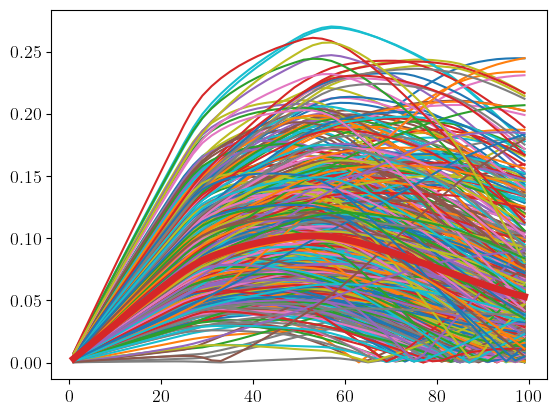

In [ ]:
for i in spd_profile :
    plt.plot(np.arange(1,100,2),np.abs(i))
plt.plot(np.arange(1,100,2),np.mean(np.abs(spd_profile),axis=0), linewidth = 5)

### Tangent profile of sample vortices compared to their modeled versions

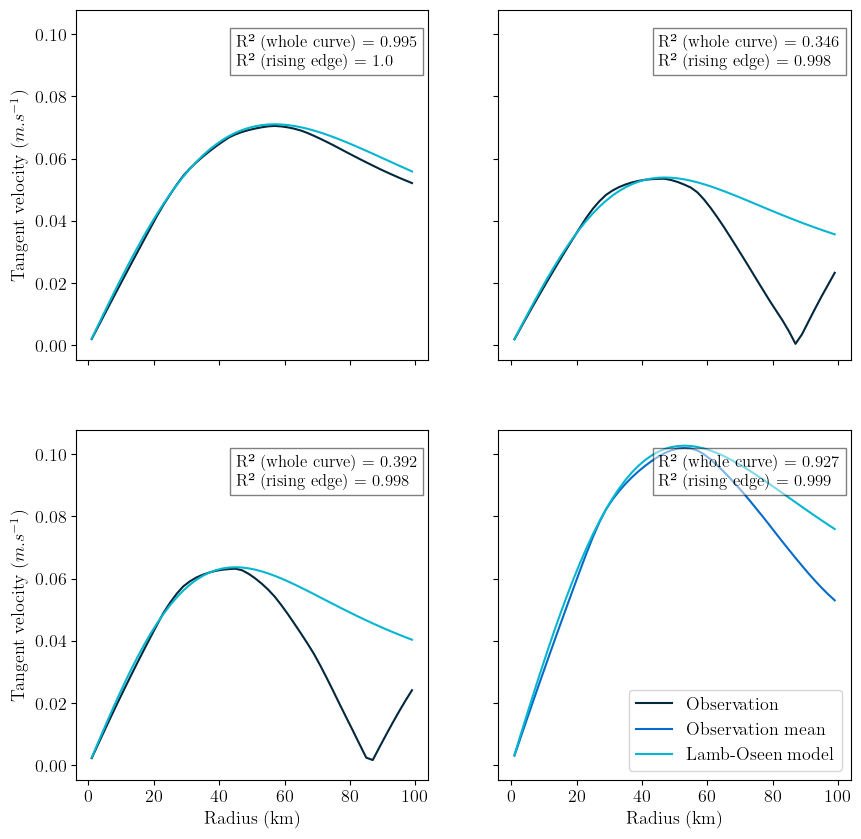

In [ ]:
X = np.arange(1,100,2)
spd_mean = np.nanmean(np.abs(spd_profile),axis=0)
circ_mean = np.nanmean(np.abs(circulation_profile),axis=0)

fig, ax = plt.subplots(2,2,figsize=(10, 10),sharex=True, sharey=True)
vprofiles = [spd_profile[5],spd_profile[50],spd_profile[30],spd_mean]
cprofiles = [circulation_profile[5],circulation_profile[50],circulation_profile[30],circ_mean]
for j in range(4):
    rmax,circ = lamb_oseen_fit(np.abs(vprofiles[j]),np.abs(cprofiles[j]))
    spd_profile_lo = circ/(2*np.pi*X*1000)*(1-np.exp(-1.25643*(X/rmax)**2))
    reg = stats.linregress(vprofiles[j],spd_profile_lo)
    reg2 = stats.linregress(vprofiles[j][:int((rmax-1)/2)],spd_profile_lo[:int((rmax-1)/2)])
    ax[j // 2][j % 2].text(45, 0.09, 'R² (whole curve) = '+str(round(reg.rvalue**2,3))+'\n R² (rising edge) = '+str(round(reg2.rvalue**2,3)), fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    if j == 3 :
        line_mean, =ax[j // 2][j % 2].plot(X,np.abs(vprofiles[j]),label='Observation mean',c =  "#056bc9")
    else :
        line_obs, = ax[j // 2][j % 2].plot(X,np.abs(vprofiles[j]),label='Observation', c = "#01283c")
    line_lo, = ax[j // 2][j % 2].plot(X,spd_profile_lo,label='Lamb-Oseen model', c = "#06b6d1")
    if j // 2 == 1 :
        ax[j // 2][j % 2].set_xlabel("Radius (km)")
    if j % 2 == 0 :
        ax[j // 2][j % 2].set_ylabel("Tangent velocity ($m.s^{-1}$)")
    if j == 3 :
        ax[j // 2][j % 2].legend([line_obs,line_mean,line_lo],['Observation','Observation mean','Lamb-Oseen model'])

In [ ]:
dsr.close()
dsrf.close()